# Detecção de Anomalias - Treino - Economiza+ MVP

**Sprint 2 - Dia 10**  
**Objetivo:** Treinar detector de anomalias com Isolation Forest

**Hipótese H6:** Isolation Forest detecta anomalias com Precision >0.85 e Recall >0.80

**Restrição:** Modelo global (não por categoria)

**Entregáveis:**
- Modelo `isolation_forest.pkl` treinado
- Predições de anomalias para todo o dataset

## 1. Setup e Carregamento de Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pickle
import os

# Configurações
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

In [2]:
# Carregar transações
transacoes = pd.read_csv('../data/raw/transacoes.csv')

print(f"Total de transações: {len(transacoes)}")
print(f"\nColunas: {list(transacoes.columns)}")
print(f"\nDistribuição de anomalias (ground truth):")
print(transacoes['is_anomalia'].value_counts())
print(f"\nPercentual de anomalias: {transacoes['is_anomalia'].mean()*100:.2f}%")

Total de transações: 194231

Colunas: ['user_id', 'data', 'categoria', 'valor', 'mes', 'ano', 'renda_mes', 'is_essencial', 'is_anomalia']

Distribuição de anomalias (ground truth):
is_anomalia
False    184520
True       9711
Name: count, dtype: int64

Percentual de anomalias: 5.00%


In [3]:
# Filtrar apenas gastos (excluir Renda)
gastos = transacoes[transacoes['categoria'] != 'Renda'].copy()

print(f"Transações de gasto: {len(gastos)}")
print(f"Anomalias em gastos: {gastos['is_anomalia'].sum()}")
print(f"Percentual: {gastos['is_anomalia'].mean()*100:.2f}%")

Transações de gasto: 191231
Anomalias em gastos: 9550
Percentual: 4.99%


## 2. Análise Exploratória das Anomalias

In [4]:
# Comparar valores normais vs anomalias
print("="*70)
print("COMPARAÇÃO: TRANSAÇÕES NORMAIS vs ANOMALIAS")
print("="*70)

normais = gastos[gastos['is_anomalia'] == False]['valor']
anomalias = gastos[gastos['is_anomalia'] == True]['valor']

print(f"\nTransações Normais:")
print(f"  Count: {len(normais)}")
print(f"  Média: R$ {normais.mean():.2f}")
print(f"  Mediana: R$ {normais.median():.2f}")
print(f"  Std: R$ {normais.std():.2f}")
print(f"  Max: R$ {normais.max():.2f}")

print(f"\nTransações Anômalas:")
print(f"  Count: {len(anomalias)}")
print(f"  Média: R$ {anomalias.mean():.2f}")
print(f"  Mediana: R$ {anomalias.median():.2f}")
print(f"  Std: R$ {anomalias.std():.2f}")
print(f"  Max: R$ {anomalias.max():.2f}")

print(f"\nRatio (anomalia/normal): {anomalias.mean()/normais.mean():.2f}x")

COMPARAÇÃO: TRANSAÇÕES NORMAIS vs ANOMALIAS

Transações Normais:
  Count: 181681
  Média: R$ 49.48
  Mediana: R$ 24.20
  Std: R$ 72.47
  Max: R$ 1380.04

Transações Anômalas:
  Count: 9550
  Média: R$ 282.39
  Mediana: R$ 133.95
  Std: R$ 425.31
  Max: R$ 6161.64

Ratio (anomalia/normal): 5.71x


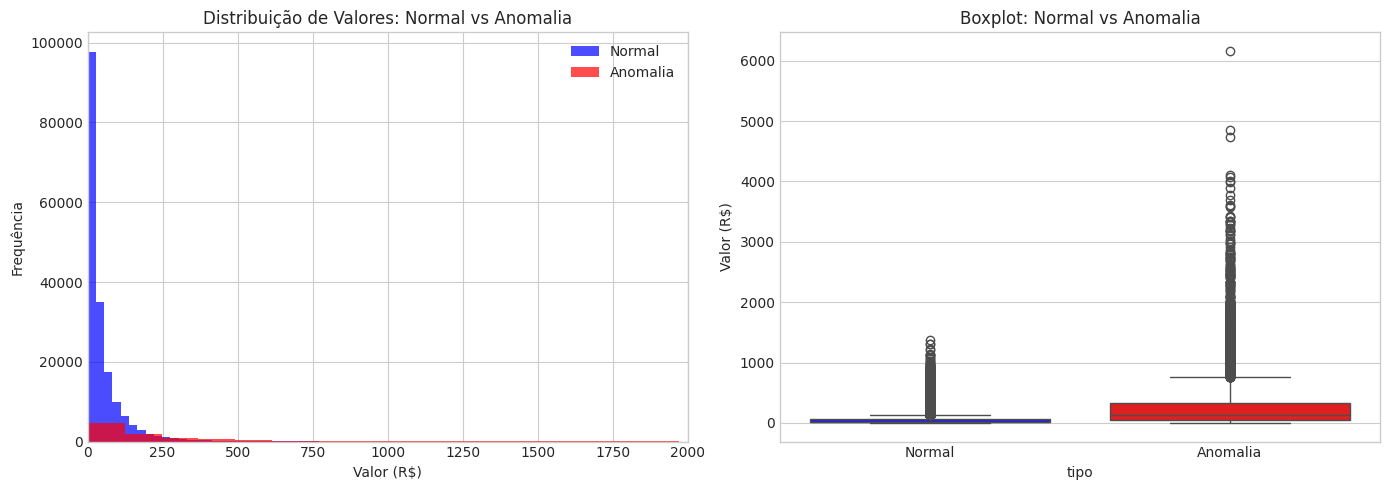

Gráfico salvo: outputs/anomalias_distribuicao.png


In [5]:
# Visualizar distribuição de valores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(normais, bins=50, alpha=0.7, label='Normal', color='blue')
axes[0].hist(anomalias, bins=50, alpha=0.7, label='Anomalia', color='red')
axes[0].set_xlabel('Valor (R$)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição de Valores: Normal vs Anomalia')
axes[0].legend()
axes[0].set_xlim(0, 2000)  # Limitar para melhor visualização

# Boxplot
gastos['tipo'] = gastos['is_anomalia'].map({True: 'Anomalia', False: 'Normal'})
sns.boxplot(data=gastos, x='tipo', y='valor', hue='tipo', ax=axes[1], palette=['blue', 'red'], legend=False)
axes[1].set_ylabel('Valor (R$)')
axes[1].set_title('Boxplot: Normal vs Anomalia')

plt.tight_layout()
plt.savefig('../outputs/anomalias_distribuicao.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/anomalias_distribuicao.png")

In [6]:
# Anomalias por categoria
print("\n" + "="*70)
print("ANOMALIAS POR CATEGORIA")
print("="*70)

anomalias_por_cat = gastos.groupby('categoria').agg({
    'is_anomalia': ['sum', 'mean', 'count']
}).round(4)
anomalias_por_cat.columns = ['num_anomalias', 'pct_anomalias', 'total_transacoes']
anomalias_por_cat['pct_anomalias'] = anomalias_por_cat['pct_anomalias'] * 100
anomalias_por_cat = anomalias_por_cat.sort_values('num_anomalias', ascending=False)

print("\n")
print(anomalias_por_cat.to_string())


ANOMALIAS POR CATEGORIA


                   num_anomalias  pct_anomalias  total_transacoes
categoria                                                        
Transporte                  1084           5.13             21124
Telecomunicacoes            1073           5.13             20933
Alimentacao_Casa            1070           5.12             20912
Habitacao_Contas            1059           5.04             21016
Saude                       1032           4.99             20680
Educacao                     999           4.77             20934
Higiene_Limpeza              997           4.76             20959
Habitacao_Aluguel            719           4.89             14693
Lazer                        410           5.46              7506
Alimentacao_Fora             387           5.22              7417
Outros                       360           4.82              7471
Vestuario                    360           4.75              7586


## 3. Feature Engineering para Detecção de Anomalias

In [7]:
# Calcular estatísticas por categoria para normalizar valores
stats_categoria = gastos.groupby('categoria')['valor'].agg(['mean', 'std', 'median']).reset_index()
stats_categoria.columns = ['categoria', 'media_cat', 'std_cat', 'mediana_cat']

print("Estatísticas por categoria:")
print(stats_categoria.to_string())

Estatísticas por categoria:
            categoria   media_cat     std_cat  mediana_cat
0    Alimentacao_Casa  108.778037  181.385125       59.680
1    Alimentacao_Fora  138.748555  221.374030       84.200
2            Educacao   29.799526   50.306776       16.500
3   Habitacao_Aluguel  150.120458  247.135047       82.230
4    Habitacao_Contas   71.128325  121.319548       39.080
5     Higiene_Limpeza   18.224483   32.525957        9.940
6               Lazer   51.552619   84.566002       29.800
7              Outros   33.742190   54.732411       19.610
8               Saude   42.948941   78.276150       22.890
9    Telecomunicacoes   18.339074   32.405372        9.970
10         Transporte   60.156934  103.033691       32.870
11          Vestuario   65.119861   96.137948       40.735


In [8]:
# Merge estatísticas com gastos
gastos_features = gastos.merge(stats_categoria, on='categoria')

# Criar features para o modelo
# Feature 1: Valor absoluto
gastos_features['feat_valor'] = gastos_features['valor']

# Feature 2: Valor normalizado pela média da categoria (z-score simplificado)
gastos_features['feat_valor_norm'] = (
    (gastos_features['valor'] - gastos_features['media_cat']) / gastos_features['std_cat']
)

# Feature 3: Ratio valor/mediana da categoria
gastos_features['feat_ratio_mediana'] = gastos_features['valor'] / gastos_features['mediana_cat']

# Feature 4: Log do valor (para lidar com skewness)
gastos_features['feat_log_valor'] = np.log1p(gastos_features['valor'])

print("Features criadas:")
print("  - feat_valor: Valor absoluto")
print("  - feat_valor_norm: Z-score por categoria")
print("  - feat_ratio_mediana: Ratio valor/mediana da categoria")
print("  - feat_log_valor: Log do valor")

gastos_features[['valor', 'categoria', 'feat_valor', 'feat_valor_norm', 'feat_ratio_mediana', 'feat_log_valor', 'is_anomalia']].head(10)

Features criadas:
  - feat_valor: Valor absoluto
  - feat_valor_norm: Z-score por categoria
  - feat_ratio_mediana: Ratio valor/mediana da categoria
  - feat_log_valor: Log do valor


,valor,categoria,feat_valor,feat_valor_norm,feat_ratio_mediana,feat_log_valor,is_anomalia
0,22.46,Alimentacao_Casa,22.46,-0.475883,0.376340,3.155297,False
1,108.32,Alimentacao_Casa,108.32,-0.002525,1.815013,4.694279,False
2,85.17,Alimentacao_Casa,85.17,-0.130154,1.427111,4.456322,False
3,88.95,Alimentacao_Casa,88.95,-0.109315,1.490449,4.499254,False
4,260.54,Alimentacao_Casa,260.54,0.836684,4.365617,5.566587,False
5,137.88,Alimentacao_Casa,137.88,0.160443,2.310322,4.933610,False
6,255.03,Alimentacao_Fora,255.03,0.525271,3.028860,5.545295,False
7,29.37,Habitacao_Aluguel,29.37,-0.488601,0.357169,3.413455,False
8,32.32,Habitacao_Aluguel,32.32,-0.476664,0.393044,3.506158,False
9,78.55,Habitacao_Aluguel,78.55,-0.289601,0.955247,4.376386,False


In [9]:
# Verificar correlação das features com anomalias
print("\n" + "="*70)
print("CORRELAÇÃO DAS FEATURES COM ANOMALIAS")
print("="*70)

features_cols = ['feat_valor', 'feat_valor_norm', 'feat_ratio_mediana', 'feat_log_valor']

for feat in features_cols:
    corr = gastos_features[feat].corr(gastos_features['is_anomalia'].astype(int))
    print(f"  {feat}: {corr:.4f}")


CORRELAÇÃO DAS FEATURES COM ANOMALIAS
  feat_valor: 0.3938
  feat_valor_norm: 0.4898
  feat_ratio_mediana: 0.4872
  feat_log_valor: 0.2613


## 4. Preparação dos Dados para Treino

In [10]:
# Selecionar features para o modelo
# Usando apenas feat_valor_norm e feat_ratio_mediana (mais discriminativas)
FEATURES_MODELO = ['feat_valor_norm', 'feat_ratio_mediana']

X = gastos_features[FEATURES_MODELO].copy()
y_true = gastos_features['is_anomalia'].astype(int).values

# Tratar valores infinitos ou NaN
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"Shape dos dados: {X.shape}")
print(f"Features: {FEATURES_MODELO}")
print(f"\nEstatísticas das features:")
print(X.describe())

Shape dos dados: (191231, 2)
Features: ['feat_valor_norm', 'feat_ratio_mediana']

Estatísticas das features:
       feat_valor_norm  feat_ratio_mediana
count     1.912310e+05       191231.000000
mean      7.134001e-18            1.807141
std       9.999712e-01            3.094166
min      -6.772545e-01            0.000000
25%      -4.541478e-01            0.406090
50%      -2.614965e-01            1.000000
75%       1.084785e-01            2.134403
max       3.547567e+01          123.191242


In [11]:
# Normalizar features com StandardScaler
scaler_anomalias = StandardScaler()
X_scaled = scaler_anomalias.fit_transform(X)

print("Features normalizadas com StandardScaler")
print(f"Shape: {X_scaled.shape}")

Features normalizadas com StandardScaler
Shape: (191231, 2)


## 5. Treinar Isolation Forest

In [12]:
# Parâmetros do modelo
# contamination = proporção esperada de anomalias (5% no dataset)
CONTAMINATION = 0.05

print("="*70)
print("TREINAMENTO DO ISOLATION FOREST")
print("="*70)
print(f"\nParâmetros:")
print(f"  - contamination: {CONTAMINATION}")
print(f"  - n_estimators: 100 (default)")
print(f"  - random_state: 42")

TREINAMENTO DO ISOLATION FOREST

Parâmetros:
  - contamination: 0.05
  - n_estimators: 100 (default)
  - random_state: 42


In [13]:
# Treinar modelo
isolation_forest = IsolationForest(
    contamination=CONTAMINATION,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

isolation_forest.fit(X_scaled)

print("\nModelo treinado com sucesso!")


Modelo treinado com sucesso!


In [14]:
# Gerar predições
# Isolation Forest retorna: 1 para normal, -1 para anomalia
y_pred_raw = isolation_forest.predict(X_scaled)

# Converter para 0/1 (0=normal, 1=anomalia)
y_pred = (y_pred_raw == -1).astype(int)

print(f"\nPredições geradas:")
print(f"  Normais detectados: {(y_pred == 0).sum()}")
print(f"  Anomalias detectadas: {(y_pred == 1).sum()}")
print(f"  Percentual anomalias: {y_pred.mean()*100:.2f}%")


Predições geradas:
  Normais detectados: 181672
  Anomalias detectadas: 9559
  Percentual anomalias: 5.00%


In [15]:
# Obter scores de anomalia (quanto menor, mais anômalo)
anomaly_scores = isolation_forest.decision_function(X_scaled)

# Adicionar ao dataframe
gastos_features['anomaly_score'] = anomaly_scores
gastos_features['pred_anomalia'] = y_pred

print("Scores de anomalia calculados")
print(f"\nScore médio - Normais (ground truth): {gastos_features[gastos_features['is_anomalia']==False]['anomaly_score'].mean():.4f}")
print(f"Score médio - Anomalias (ground truth): {gastos_features[gastos_features['is_anomalia']==True]['anomaly_score'].mean():.4f}")

Scores de anomalia calculados

Score médio - Normais (ground truth): 0.1434
Score médio - Anomalias (ground truth): -0.0031


## 6. Avaliação Preliminar

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Calcular métricas
print("="*70)
print("AVALIAÇÃO PRELIMINAR")
print("="*70)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\n>>> PRECISION: {precision:.4f} (target: >0.85)")
print(f">>> RECALL: {recall:.4f} (target: >0.80)")
print(f">>> F1-SCORE: {f1:.4f}")

# Status
precision_ok = precision >= 0.85
recall_ok = recall >= 0.80

print(f"\nStatus Precision: {'ATINGIDO' if precision_ok else 'NÃO ATINGIDO'}")
print(f"Status Recall: {'ATINGIDO' if recall_ok else 'NÃO ATINGIDO'}")

AVALIAÇÃO PRELIMINAR

>>> PRECISION: 0.4732 (target: >0.85)
>>> RECALL: 0.4736 (target: >0.80)
>>> F1-SCORE: 0.4734

Status Precision: NÃO ATINGIDO
Status Recall: NÃO ATINGIDO


In [17]:
# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)

print("\nMatriz de Confusão:")
print(f"                 Pred Normal  Pred Anomalia")
print(f"Real Normal      {cm[0,0]:>10}  {cm[0,1]:>13}")
print(f"Real Anomalia    {cm[1,0]:>10}  {cm[1,1]:>13}")

print(f"\nInterpretação:")
print(f"  True Negatives (TN): {cm[0,0]} - Normais corretamente identificados")
print(f"  False Positives (FP): {cm[0,1]} - Normais classificados como anomalia")
print(f"  False Negatives (FN): {cm[1,0]} - Anomalias não detectadas")
print(f"  True Positives (TP): {cm[1,1]} - Anomalias corretamente detectadas")


Matriz de Confusão:
                 Pred Normal  Pred Anomalia
Real Normal          176645           5036
Real Anomalia          5027           4523

Interpretação:
  True Negatives (TN): 176645 - Normais corretamente identificados
  False Positives (FP): 5036 - Normais classificados como anomalia
  False Negatives (FN): 5027 - Anomalias não detectadas
  True Positives (TP): 4523 - Anomalias corretamente detectadas


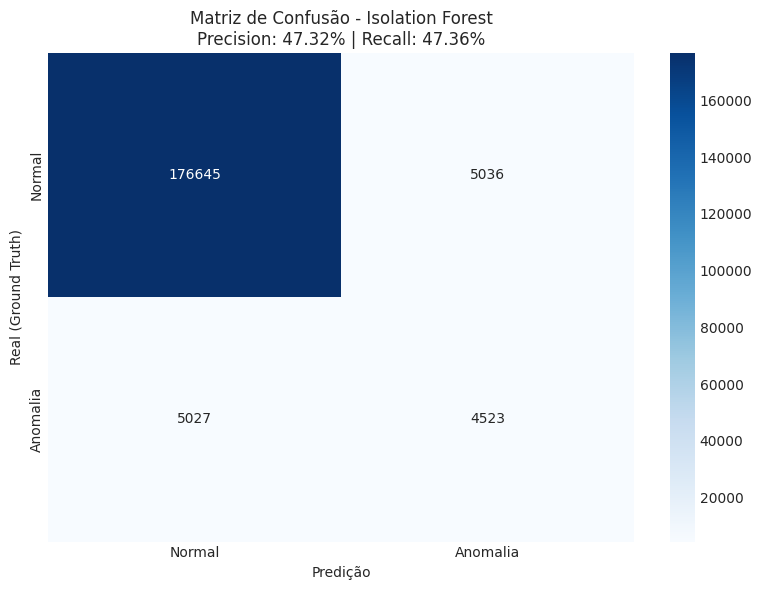

Gráfico salvo: outputs/matriz_confusao_anomalias.png


In [18]:
# Visualizar matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Normal', 'Anomalia'],
            yticklabels=['Normal', 'Anomalia'])
ax.set_xlabel('Predição')
ax.set_ylabel('Real (Ground Truth)')
ax.set_title(f'Matriz de Confusão - Isolation Forest\nPrecision: {precision:.2%} | Recall: {recall:.2%}')

plt.tight_layout()
plt.savefig('../outputs/matriz_confusao_anomalias.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/matriz_confusao_anomalias.png")

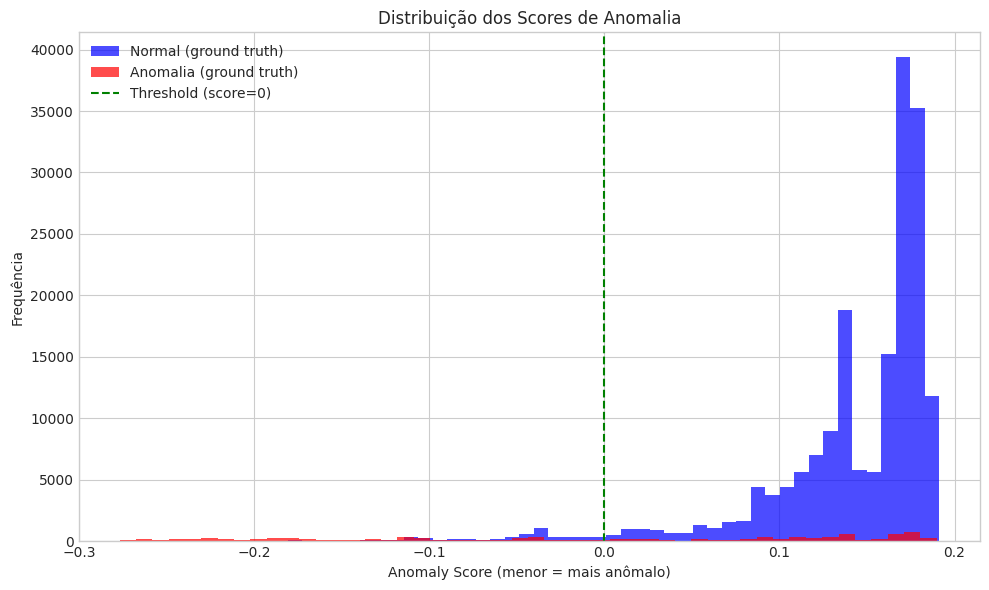

Gráfico salvo: outputs/distribuicao_scores_anomalia.png


In [19]:
# Visualizar distribuição dos scores
fig, ax = plt.subplots(figsize=(10, 6))

scores_normais = gastos_features[gastos_features['is_anomalia']==False]['anomaly_score']
scores_anomalias = gastos_features[gastos_features['is_anomalia']==True]['anomaly_score']

ax.hist(scores_normais, bins=50, alpha=0.7, label='Normal (ground truth)', color='blue')
ax.hist(scores_anomalias, bins=50, alpha=0.7, label='Anomalia (ground truth)', color='red')
ax.axvline(x=0, color='green', linestyle='--', label='Threshold (score=0)')
ax.set_xlabel('Anomaly Score (menor = mais anômalo)')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição dos Scores de Anomalia')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/distribuicao_scores_anomalia.png', dpi=150, bbox_inches='tight')
plt.show()
print("Gráfico salvo: outputs/distribuicao_scores_anomalia.png")

## 7. Salvar Modelo e Artefatos

In [20]:
# Criar diretório models se não existir
os.makedirs('../models', exist_ok=True)

# Salvar modelo Isolation Forest
with open('../models/isolation_forest.pkl', 'wb') as f:
    pickle.dump(isolation_forest, f)
print("Modelo salvo: models/isolation_forest.pkl")

# Salvar scaler
with open('../models/scaler_anomalias.pkl', 'wb') as f:
    pickle.dump(scaler_anomalias, f)
print("Scaler salvo: models/scaler_anomalias.pkl")

# Salvar estatísticas por categoria (necessário para novas predições)
stats_categoria.to_csv('../models/stats_categoria_anomalias.csv', index=False)
print("Estatísticas salvas: models/stats_categoria_anomalias.csv")

Modelo salvo: models/isolation_forest.pkl
Scaler salvo: models/scaler_anomalias.pkl
Estatísticas salvas: models/stats_categoria_anomalias.csv


In [21]:
# Salvar transações com predições
colunas_saida = [
    'user_id', 'data', 'categoria', 'valor', 'mes', 'ano',
    'is_essencial', 'is_anomalia', 'anomaly_score', 'pred_anomalia'
]

transacoes_com_pred = gastos_features[colunas_saida].copy()
transacoes_com_pred.to_csv('../data/processed/transacoes_com_anomalias_pred.csv', index=False)

print(f"\nTransações com predições salvas: data/processed/transacoes_com_anomalias_pred.csv")
print(f"Total de linhas: {len(transacoes_com_pred)}")


Transações com predições salvas: data/processed/transacoes_com_anomalias_pred.csv
Total de linhas: 191231


In [22]:
# Salvar configuração do modelo
import json

config_modelo = {
    'versao': '1.0',
    'data_treino': '2026-01-26',
    'modelo': 'IsolationForest',
    'parametros': {
        'contamination': CONTAMINATION,
        'n_estimators': 100,
        'random_state': 42
    },
    'features': FEATURES_MODELO,
    'metricas_treino': {
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1_score': round(f1, 4)
    },
    'targets': {
        'precision': 0.85,
        'recall': 0.80
    },
    'arquivos': {
        'modelo': 'isolation_forest.pkl',
        'scaler': 'scaler_anomalias.pkl',
        'stats_categoria': 'stats_categoria_anomalias.csv'
    }
}

with open('../models/config_anomalias.json', 'w', encoding='utf-8') as f:
    json.dump(config_modelo, f, indent=2, ensure_ascii=False)

print("Configuração salva: models/config_anomalias.json")

Configuração salva: models/config_anomalias.json


## 8. Função de Predição para Novos Dados

In [23]:
def detectar_anomalia(transacao, modelo, scaler, stats_cat):
    """
    Detecta se uma transação é anômala.
    
    Parâmetros:
        transacao: dict com 'valor' e 'categoria'
        modelo: IsolationForest treinado
        scaler: StandardScaler treinado
        stats_cat: DataFrame com estatísticas por categoria
    
    Retorna:
        dict com 'is_anomalia', 'score', 'confianca'
    """
    valor = transacao['valor']
    categoria = transacao['categoria']
    
    # Buscar estatísticas da categoria
    cat_stats = stats_cat[stats_cat['categoria'] == categoria]
    
    if len(cat_stats) == 0:
        # Categoria desconhecida - usar média geral
        media_cat = stats_cat['media_cat'].mean()
        std_cat = stats_cat['std_cat'].mean()
        mediana_cat = stats_cat['mediana_cat'].mean()
    else:
        media_cat = cat_stats['media_cat'].values[0]
        std_cat = cat_stats['std_cat'].values[0]
        mediana_cat = cat_stats['mediana_cat'].values[0]
    
    # Calcular features
    feat_valor_norm = (valor - media_cat) / std_cat if std_cat > 0 else 0
    feat_ratio_mediana = valor / mediana_cat if mediana_cat > 0 else 0
    
    # Preparar input
    X = np.array([[feat_valor_norm, feat_ratio_mediana]])
    X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)
    X_scaled = scaler.transform(X)
    
    # Predição
    pred = modelo.predict(X_scaled)[0]
    score = modelo.decision_function(X_scaled)[0]
    
    is_anomalia = pred == -1
    
    return {
        'is_anomalia': is_anomalia,
        'score': round(score, 4),
        'confianca': 'alta' if abs(score) > 0.1 else 'media' if abs(score) > 0.05 else 'baixa'
    }

print("Função detectar_anomalia() definida!")

Função detectar_anomalia() definida!


In [24]:
# Testar função com exemplos
print("\n" + "="*70)
print("TESTE DA FUNÇÃO DE DETECÇÃO")
print("="*70)

exemplos = [
    {'valor': 50.0, 'categoria': 'Alimentacao_Fora', 'descricao': 'Gasto normal'},
    {'valor': 500.0, 'categoria': 'Alimentacao_Fora', 'descricao': 'Gasto alto'},
    {'valor': 1500.0, 'categoria': 'Alimentacao_Fora', 'descricao': 'Gasto muito alto'},
    {'valor': 100.0, 'categoria': 'Vestuario', 'descricao': 'Gasto normal'},
    {'valor': 800.0, 'categoria': 'Vestuario', 'descricao': 'Gasto alto'},
]

for ex in exemplos:
    resultado = detectar_anomalia(ex, isolation_forest, scaler_anomalias, stats_categoria)
    status = "ANOMALIA" if resultado['is_anomalia'] else "NORMAL"
    print(f"\n{ex['descricao']} - {ex['categoria']}: R$ {ex['valor']:.2f}")
    print(f"  -> {status} (score: {resultado['score']}, confiança: {resultado['confianca']})")


TESTE DA FUNÇÃO DE DETECÇÃO

Gasto normal - Alimentacao_Fora: R$ 50.00
  -> NORMAL (score: 0.1837, confiança: alta)

Gasto alto - Alimentacao_Fora: R$ 500.00
  -> ANOMALIA (score: -0.0393, confiança: baixa)

Gasto muito alto - Alimentacao_Fora: R$ 1500.00
  -> ANOMALIA (score: -0.2077, confiança: alta)

Gasto normal - Vestuario: R$ 100.00
  -> NORMAL (score: 0.1032, confiança: alta)

Gasto alto - Vestuario: R$ 800.00
  -> ANOMALIA (score: -0.2196, confiança: alta)


/home/celina/.pyenv/versions/economiza-ia-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/celina/.pyenv/versions/economiza-ia-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/celina/.pyenv/versions/economiza-ia-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/celina/.pyenv/versions/economiza-ia-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/celina/.pyenv/versions/economiza-ia-env/lib/python3.12/site-packages/sklearn/utils/validation.

## 9. Checklist e Próximos Passos

In [25]:
# Checklist Dia 10
print("\n" + "="*70)
print("CHECKLIST DIA 10")
print("="*70)
print("\n[x] Carregar e analisar transações")
print("[x] Feature engineering para anomalias")
print("[x] Treinar Isolation Forest global")
print("[x] Gerar predições para todo o dataset")
print("[x] Avaliação preliminar (precision, recall)")
print("[x] Salvar modelo e artefatos")
print("[x] Criar função de predição para novos dados")
print("\n>>> DIA 10 CONCLUÍDO!")
print("\nPróximo passo (Dia 11): Validação detalhada da H6 e ajustes")


CHECKLIST DIA 10

[x] Carregar e analisar transações
[x] Feature engineering para anomalias
[x] Treinar Isolation Forest global
[x] Gerar predições para todo o dataset
[x] Avaliação preliminar (precision, recall)
[x] Salvar modelo e artefatos
[x] Criar função de predição para novos dados

>>> DIA 10 CONCLUÍDO!

Próximo passo (Dia 11): Validação detalhada da H6 e ajustes


In [26]:
# Resumo final
print("\n" + "="*70)
print("RESUMO FINAL - DIA 10")
print("="*70)
print(f"\nModelo: Isolation Forest")
print(f"Features: {FEATURES_MODELO}")
print(f"Contamination: {CONTAMINATION}")
print(f"\nMétricas preliminares:")
print(f"  Precision: {precision:.4f} (target: >0.85) - {'OK' if precision_ok else 'AJUSTAR'}")
print(f"  Recall: {recall:.4f} (target: >0.80) - {'OK' if recall_ok else 'AJUSTAR'}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nArquivos gerados:")
print("  - models/isolation_forest.pkl")
print("  - models/scaler_anomalias.pkl")
print("  - models/stats_categoria_anomalias.csv")
print("  - models/config_anomalias.json")
print("  - data/processed/transacoes_com_anomalias_pred.csv")
print("  - outputs/anomalias_distribuicao.png")
print("  - outputs/matriz_confusao_anomalias.png")
print("  - outputs/distribuicao_scores_anomalia.png")


RESUMO FINAL - DIA 10

Modelo: Isolation Forest
Features: ['feat_valor_norm', 'feat_ratio_mediana']
Contamination: 0.05

Métricas preliminares:
  Precision: 0.4732 (target: >0.85) - AJUSTAR
  Recall: 0.4736 (target: >0.80) - AJUSTAR
  F1-Score: 0.4734

Arquivos gerados:
  - models/isolation_forest.pkl
  - models/scaler_anomalias.pkl
  - models/stats_categoria_anomalias.csv
  - models/config_anomalias.json
  - data/processed/transacoes_com_anomalias_pred.csv
  - outputs/anomalias_distribuicao.png
  - outputs/matriz_confusao_anomalias.png
  - outputs/distribuicao_scores_anomalia.png
